# Truncated potentials for long-range electrostatics

_Björn Stenqvist and Mikael Lund, Div. of Theoretical Chemistry, Lund University, Sweden, 2016_

In this notebook we test the validity of a variety of Wolf-inspired potentials and compare with a default Ewald summation on a sinple box of water.

Install prerequisites using `conda`:
```bash
    $ conda config --add channels omnia
    $ conda install -c omnia openmm mdtraj packmol
```

Also, Gromacs analysis tools (`gmx`) must be installed for parts of the analysis.

In [1]:
%matplotlib inline
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from sys import stdout
import matplotlib, matplotlib.pyplot as plt
import pandas as pd
from io import StringIO
import numpy as np, os
matplotlib.rcParams.update({'font.size': 12})

# simulation parameters

nsteps     = 50000          # number of MD steps each of 2 fs
nwater     = 1000           # number of water molecules
cutoff     = 1.2*nanometers # pair potential cutoff
platform   = 'OpenCL'       # 'OpenCL', 'CUDA', 'CPU'

rho        = 216/18.6206**3 # density from gromacs spc216.gro
boxlen     = (nwater/rho)**(1/3)

print('box length = ', boxlen*angstrom)
print('half box   = ', boxlen*angstrom/2)

box length =  31.034333333333326 A
half box   =  15.517166666666663 A


### Create initial box of water

First create a single water molecule pdb file, then use this to fill up a predefined box using the command line tool `packmol`. In this example, $N$ and $L$ are taken form the Gromacs `spc216.gro` file.

In [2]:
%%writefile hoh.pdb
CRYST1   30.000   30.000   30.000  90.00  90.00  90.00 P 1           1
ATOM      1  OW  HOH A   1      27.552  11.051   7.172  1.00  0.00          O
ATOM      2  HW1 HOH A   1      27.900  10.721   8.050  1.00  0.00          H
ATOM      3  HW2 HOH A   1      26.606  11.355   7.281  1.00  0.00          H 
END

Overwriting hoh.pdb


In [3]:
# write input file for packmol
PACKMOL_INPUT = """ 
tolerance %f
filetype pdb
output %s

# hoh will be put in a box
# defined by the minimum coordinates x, y and z = 0. 0. 0. and maximum
# coordinates box_size box_size box_size That is, they will be put in a cube of side
# box_size (the keyword "inside cube 0. 0. 0. box_size") could be used as well.

structure %s
  number %d
  inside box 0. 0. 0. %f %f %f 
  add_box_sides 0.0
end structure
""" % (2.,'water.pdb','hoh.pdb', nwater, boxlen, boxlen, boxlen)

!echo '$PACKMOL_INPUT' > packmol_input.txt
!packmol < packmol_input.txt > /dev/null

### Create OpenMM `System` classes for a variety of long-range correction schemes

Here the idea is to create all the different setups and add then to the `systemlist` dictionary. Ewald summation (and PME) can be setup using the default `NonbondedForce` class, while `CustomNonbondedForce` must be used for custom pair potentials as used in Wolf, Stenqvist etc.

For more information on how to control force objects and simulation, check,

* [OpenMM python API](http://docs.openmm.org).
* Lennard-Jones + Ewald at http://docs.openmm.org/7.0.0/userguide/theory.html#nonbondedforce
* Long range correction beyond cut-off: http://docs.openmm.org/7.0.0/userguide/theory.html#customnonbondedforce

_TODO_: Smoothen LJ part at $R_c$. Use switching function?

In [4]:
elec_to_kJmol = (
    constants.elementary_charge**2 *
    AVOGADRO_CONSTANT_NA / (4*np.pi*1.0*8.854187817e-12
                            * constants.farad/constants.meter)).value_in_unit(kilojoule_per_mole*nanometer)

def findForce(system, forcetype, add=True):
    """ Finds a specific force in the system force list - added if not found."""
    for force in system.getForces():
        if isinstance(force, forcetype):
            return force
    if add==True:
        system.addForce(forcetype())
        return findForce(system, forcetype)
    return None

def make_qpotential_system(topology, Rc=0.9*nanometers, moments=1000):
    ''' return a q-potential system (TO '''
    
    ff = ForceField('spce-custom.xml') # this will create a CustomNonbondedForce
    system = ff.createSystem(
        topology, nonbondedMethod=CutoffPeriodic,
        nonbondedCutoff=Rc, constraints=HBonds, rigidWater=True)
    
    def qPochhammerSymbol( Rc, moments ):
        if isinstance(Rc, Quantity):
            Rc = Rc / nanometer # strip unit
        qP = 1.0
        r = np.linspace(0, Rc, 5000)
        for i in range( moments ):
            qP *= (1 - (r/Rc)**(i+1) )
        return qP
 
    qP = Continuous1DFunction( qPochhammerSymbol(Rc, moments), 0*nanometers, Rc)

    nonbonded = findForce(system, CustomNonbondedForce)
    nonbonded.addTabulatedFunction( 'qP', qP )         # 'qP(r)' can now be used in energy function
    nonbonded.addGlobalParameter( 'f', elec_to_kJmol ) # convert to kJ/mol
    
    nonbonded.setEnergyFunction(
        'f * charge1 * charge2 * qP(r)/r' \
        ' + 4 * epsilon * ( (sigma/r)^12 - (sigma/r)^6 )' \
        ' ; sigma = 0.5 * ( sigma1+sigma2 ); epsilon = sqrt( epsilon1*epsilon2 )'
    )

    print('qpot')
    print('    periodic boundaries:  ', nonbonded.usesPeriodicBoundaryConditions())
    print('    switching function:   ', nonbonded.getUseSwitchingFunction())
    print('    long-range correction:', nonbonded.getUseLongRangeCorrection())
    print('    cutoff distance:      ', nonbonded.getCutoffDistance())
    print('    energy function:      ', nonbonded.getEnergyFunction())
    
    return system

def make_grekiss_system(topology, Rc=0.9*nanometers):
    ''' return a grekis system '''
    
    ff = ForceField('spce-custom.xml') # this will create a CustomNonbondedForce
    system = ff.createSystem(
        topology, nonbondedMethod=CutoffPeriodic,
        nonbondedCutoff=Rc, constraints=HBonds, rigidWater=True)
    
    nonbonded = findForce(system, CustomNonbondedForce)
    nonbonded.addGlobalParameter( 'Rc', Rc )           # 'Rc' can now be used in energy function
    nonbonded.addGlobalParameter( 'f', elec_to_kJmol ) # 'lB' bjerrum length in nm and kJ/mol
    
    nonbonded.setEnergyFunction(
        'f * charge1 * charge2 * 1/r * ( 1 - 1.75*r/Rc + 5.25*(r/Rc)^5 - 7*(r/Rc)^6 + 2.5*(r/Rc)^7 )' \
        ' + 4 * epsilon * ( (sigma/r)^12 - (sigma/r)^6 )' \
        ' ; sigma = 0.5 * (sigma1+sigma2); epsilon = sqrt( epsilon1*epsilon2 )'
    )

    print('fanourgakis')
    print('    periodic boundaries:  ', nonbonded.usesPeriodicBoundaryConditions())
    print('    switching function:   ', nonbonded.getUseSwitchingFunction())
    print('    long-range correction:', nonbonded.getUseLongRangeCorrection())
    print('    cutoff distance:      ', nonbonded.getCutoffDistance())
    print('    energy function:      ', nonbonded.getEnergyFunction())
    
    return system

def make_yonezawa_system(topology, Rc=0.9*nanometers):
    ''' return a yonezawa system '''
    
    ff = ForceField('spce-custom.xml') # this will create a CustomNonbondedForce
    system = ff.createSystem(
        topology, nonbondedMethod=CutoffPeriodic,
        nonbondedCutoff=Rc, constraints=HBonds, rigidWater=True)

    nonbonded = findForce(system, CustomNonbondedForce)
    nonbonded.addGlobalParameter( 'Rc', Rc )           # 'Rc' can now be used in energy function
    nonbonded.addGlobalParameter( 'f', elec_to_kJmol ) # 'lB' bjerrum length in nm and kJ/mol
    
    nonbonded.setEnergyFunction(
        'f * charge1 * charge2 * ( 1/r - 1/Rc + 1/Rc^2 * (r-Rc) )' \
        ' + 4 * epsilon * ( (sigma/r)^12 - (sigma/r)^6 )' \
        ' ; sigma = 0.5 * ( sigma1+sigma2 ); epsilon = sqrt( epsilon1 * epsilon2 )'
    )

    print('yonezawa')
    print('    periodic boundaries:  ', nonbonded.usesPeriodicBoundaryConditions())
    print('    switching function:   ', nonbonded.getUseSwitchingFunction())
    print('    long-range correction:', nonbonded.getUseLongRangeCorrection())
    print('    cutoff distance:      ', nonbonded.getCutoffDistance())
    print('    energy function:      ', nonbonded.getEnergyFunction())
    
    return system

def make_ewald_system(topology, Rc=0.9*nanometers, method=Ewald, ljcorr=False):
    ''' returns an Ewald system '''
    ff = ForceField('spce.xml') # this will create a NonbondedForce
    
    system = ff.createSystem(
        topology, nonbondedMethod=method,
        nonbondedCutoff=Rc, constraints=HBonds, rigidWater=True)
    
    nonbonded = findForce(system, NonbondedForce)
    nonbonded.setUseDispersionCorrection( ljcorr )

    print('ewald')
    print('    err. tolerance:       ', nonbonded.getEwaldErrorTolerance())
    print('    LJ switching function:', nonbonded.getUseSwitchingFunction())
    print('    LJ correction:        ', nonbonded.getUseDispersionCorrection())
    print('    cutoff distance:      ', nonbonded.getCutoffDistance())
 
    return system

pdb = PDBFile('water.pdb')

# here we define our list of system incl. plotting properties. All files from simulation
# and analysis will be prefixed with 'qpot.', 'ewald.', etc.

systemlist = {
    'yonezawa': {
        'system': make_yonezawa_system( pdb.topology, Rc=cutoff ), 'npt': False,
        'run': False, 'color': 'blue', 'label': 'Yonezawa'
    },
    'grekiss': {
        'system': make_grekiss_system( pdb.topology, Rc=cutoff ), 'npt': False,
        'run': False, 'color': 'green', 'label': 'Fanourgakis'
    },
    'qpot' : {
        'system': make_qpotential_system( pdb.topology, Rc=cutoff ), 'npt': False,
        'run': False, 'color': 'red', 'label': '$q$ ($n=\infty$)'
    },
    'qpot2' : {
        'system': make_qpotential_system( pdb.topology, Rc=cutoff, moments=2 ), 'npt': False,
        'run': False, 'color': 'orange', 'label': '$q$ ($n=2$)'
    },
    'qpot3' : {
        'system': make_qpotential_system( pdb.topology, Rc=cutoff, moments=3 ), 'npt': False,
        'run': False, 'color': 'magenta', 'label': '$q$ ($n=3$)'
    },
    'ewald': {
        'system': make_ewald_system( pdb.topology, Rc=cutoff ), 'npt': False,
        'run': False, 'color': 'black', 'label': 'Ewald'
    }
}

yonezawa
    periodic boundaries:   True
    switching function:    False
    long-range correction: False
    cutoff distance:       1.2 nm
    energy function:       f * charge1 * charge2 * ( 1/r - 1/Rc + 1/Rc^2 * (r-Rc) ) + 4 * epsilon * ( (sigma/r)^12 - (sigma/r)^6 ) ; sigma = 0.5 * ( sigma1+sigma2 ); epsilon = sqrt( epsilon1 * epsilon2 )
fanourgakis
    periodic boundaries:   True
    switching function:    False
    long-range correction: False
    cutoff distance:       1.2 nm
    energy function:       f * charge1 * charge2 * 1/r * ( 1 - 1.75*r/Rc + 5.25*(r/Rc)^5 - 7*(r/Rc)^6 + 2.5*(r/Rc)^7 ) + 4 * epsilon * ( (sigma/r)^12 - (sigma/r)^6 ) ; sigma = 0.5 * (sigma1+sigma2); epsilon = sqrt( epsilon1*epsilon2 )
qpot
    periodic boundaries:   True
    switching function:    False
    long-range correction: False
    cutoff distance:       1.2 nm
    energy function:       f * charge1 * charge2 * qP(r)/r + 4 * epsilon * ( (sigma/r)^12 - (sigma/r)^6 ) ; sigma = 0.5 * ( sigma1+sigma2 )

Here we perform the actual MD simulation, incl. minimization of all defined systems

In [5]:
for name, prop in systemlist.items(): # loop over systems
    
    if prop['run']:

        print(name)

        if prop['npt']: # NVT -> NPT ensemble ?
            print('    adding barostat.')
            barostat = MonteCarloBarostat(1.0*bar, 298.15*kelvin, 25) 
            system.addForce(barostat)

        integrator = LangevinIntegrator( 298.15*kelvin, 1.0/picoseconds, 2*femtoseconds )
        integrator.setConstraintTolerance(0.00001)
        _platform = Platform.getPlatformByName( platform ) # CPU, OpenCL
        sim = Simulation(pdb.topology, prop['system'], integrator, _platform)
        sim.context.setPositions(pdb.positions) # set particle positions

        if os.path.isfile( name+'.chk' ):
            with open( name+'.chk', 'rb') as f:
                print('    loading restart file.')
                sim.context.loadCheckpoint( f.read() )
        else:
            print('    minimizing energy...')
            sim.reporters.clear()
            %time sim.minimizeEnergy( tolerance=50*kilojoule/mole, maxIterations=1000 )
            sim.context.setVelocitiesToTemperature( 298.15*kelvin ) # initial random velocities

        print('    running Production...')
        sim.reporters.clear()
        sim.reporters.append( DCDReporter( name+'.dcd', 1000) )

        sim.reporters.append( StateDataReporter(name+'.energy', 1000, step=True, potentialEnergy=True,
                                                temperature=True, density=True) )

        sim.reporters.append( StateDataReporter(stdout, 1000, step=True, potentialEnergy=True,
                                                temperature=True, density=True, separator='\t',
                                                progress=True,
                                                totalSteps = nsteps) )

        %time sim.step( nsteps )

        with open( name+'.chk', 'wb') as f:
            print('    saving restart file.')
            f.write( sim.context.createCheckpoint() )

        # save final configuration to PDB file
        # todo: something is fishy here... water molecules are outside the box
        #       in pdb although the trajectory looks fine. Å->nm problem?
        positions = sim.context.getState( getPositions=True ).getPositions()
        PDBFile.writeFile(sim.topology, positions, open( name+'.pdb', 'w'))
        print()

### Oxygen-oxygen radial distribution function

yonezawa
qpot3
qpot2
grekiss
ewald
qpot


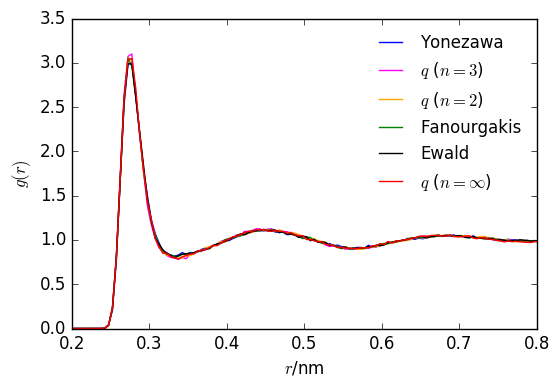

In [6]:
import mdtraj as md

for name, prop in systemlist.items():
    print(name)
    
    traj = md.load(name+'.dcd', top=name+'.pdb')
    sel = traj.top.select('name O')
    OOpairs = traj.top.select_pairs('name O', 'name O')
    rdf = md.compute_rdf( traj, pairs=OOpairs, bin_width=0.005, r_range=[0.2, boxlen/2/10] )
    
    plt.plot( rdf[0], rdf[1], label=prop['label'], color=prop['color'], lw=1)

plt.xlim(0.2, 0.8)
plt.xlabel(r'$r$/nm')
plt.ylabel(r'$g(r)$')
plt.legend(loc=0, frameon=False, fontsize='medium')

### Average potential energy

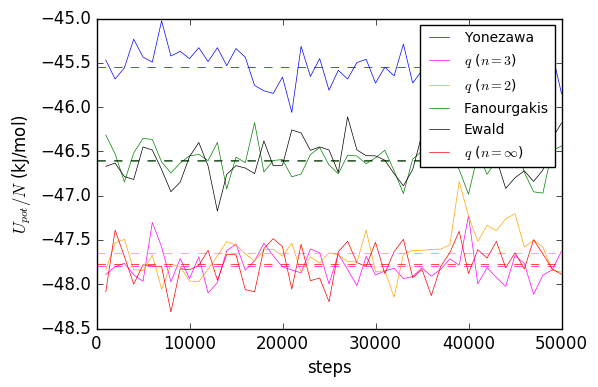

In [7]:
for name, prop in systemlist.items():

    step, Upot, temp, density = np.loadtxt(name+'.energy', skiprows=1, delimiter=',', unpack=True)
    Upot = Upot / pdb.topology.getNumResidues() # -> energy per water molecule

    plt.plot( step, Upot, label=prop['label'], color=prop['color'], lw=0.5 )
    plt.plot( [0,step.max()], [Upot.mean(), Upot.mean()], color=prop['color'], ls='--', lw=0.5 )
    prop['energy'] = Upot.mean()

plt.xlabel(r'steps')
plt.ylabel(r'$U_{pot}/N$ (kJ/mol)')
plt.legend(loc=1, frameon=True, fontsize='small')    

### Static dielectric constant

The exact formula for $\epsilon_r$ is not given in the `mdtraj` documentation, but can be found in the source code on github,

https://github.com/mdtraj/mdtraj/blob/master/mdtraj/geometry/thermodynamic_properties.py#L90

In [8]:
def getChargeVector( force, stripunit=True ):
    ''' Extract particle charge array from force object if available
    
    Note that this function assumes that charge is located at parameter
    position 0 which is default in NonbondedForce while it can be anywhere
    in CustomNonbondedForce, following the order in which
    parameters were added in python/xml.
    '''
    if isinstance(force, (NonbondedForce, CustomNonbondedForce) ):
        if 'getParticleParameters' in dir(force):
            chargelist = []
            for i in range( force.getNumParticles() ):
                charge = force.getParticleParameters( i )[ 0 ]
                if stripunit:
                    if isinstance(charge, Quantity):
                        charge = charge / elementary_charge # strip unit
                chargelist.append( charge )
            return chargelist
    return None
    
for name, prop in systemlist.items():

    for force in prop['system'].getForces():
        if isinstance(force, (NonbondedForce, CustomNonbondedForce) ):
            charges = getChargeVector( force )
            traj = md.load(name+'.dcd', top=name+'.pdb')

            l = len(traj)
            l2= int(l/2)
            
            eps12= md.static_dielectric( traj[1:l], charges, temperature=298.15)  # all
            eps1 = md.static_dielectric( traj[1:l2], charges, temperature=298.15) # 1st half
            eps2 = md.static_dielectric( traj[l2:l], charges, temperature=298.15) # 2nd half
            
            prop['diel'] = eps12
            
            print(name, ': diel. const.', eps12, eps1, eps2)

pd.DataFrame(systemlist).T

yonezawa : diel. const. 42.02683958331683 45.07688510418477 36.03939501533833
qpot3 : diel. const. 64.44432367546314 38.59947266370816 58.607243782632644
qpot2 : diel. const. 47.43000978812144 31.77471609293453 36.6028447849479
grekiss : diel. const. 40.057629674951826 29.764932340709397 33.69048586647194
ewald : diel. const. 69.07488524130184 31.88659664710486 61.47921297200237
qpot : diel. const. 100.53668382053993 120.86551044283142 60.11427212076403


,color,diel,energy,label,npt,run,system
ewald,black,69.0749,-46.5952,Ewald,False,False,<simtk.openmm.openmm.System; proxy of <Swig Ob...
grekiss,green,40.0576,-46.6129,Fanourgakis,False,False,<simtk.openmm.openmm.System; proxy of <Swig Ob...
qpot,red,100.537,-47.7709,$q$ ($n=\infty$),False,False,<simtk.openmm.openmm.System; proxy of <Swig Ob...
qpot2,orange,47.43,-47.6477,$q$ ($n=2$),False,False,<simtk.openmm.openmm.System; proxy of <Swig Ob...
qpot3,magenta,64.4443,-47.7975,$q$ ($n=3$),False,False,<simtk.openmm.openmm.System; proxy of <Swig Ob...
yonezawa,blue,42.0268,-45.5455,Yonezawa,False,False,<simtk.openmm.openmm.System; proxy of <Swig Ob...


## Gromacs analysis

We now generate a topology (top/tpr) file for Gromacs in order to use use their analysis tools, in particular for dipol correlations. These files are identitical for all electrostatic schemes.
**NOTE**: Depending on the size of the water box, `grompp` may complain that the cut-off is too short. Fix this by increasing the verlet tolerance. It will not matter for the analysis, but consider making a slightly larger system. 

In [15]:
%%bash
rm -fR 
echo -n "6\n" | gmx -quiet -nobackup pdb2gmx -f water.pdb -o water.gro -p water.top -n water.ndx -water spce
gmx -quiet -nobackup grompp -f water.mdp -c water.gro -p water.top -o water.tpr -maxwarn 10


Select the Force Field:
From '/opt/local/share/gromacs/top':
 1: AMBER03 protein, nucleic AMBER94 (Duan et al., J. Comp. Chem. 24, 1999-2012, 2003)
 2: AMBER94 force field (Cornell et al., JACS 117, 5179-5197, 1995)
 3: AMBER96 protein, nucleic AMBER94 (Kollman et al., Acc. Chem. Res. 29, 461-469, 1996)
 4: AMBER99 protein, nucleic AMBER94 (Wang et al., J. Comp. Chem. 21, 1049-1074, 2000)
 5: AMBER99SB protein, nucleic AMBER94 (Hornak et al., Proteins 65, 712-725, 2006)
 6: AMBER99SB-ILDN protein, nucleic AMBER94 (Lindorff-Larsen et al., Proteins 78, 1950-58, 2010)
 7: AMBERGS force field (Garcia & Sanbonmatsu, PNAS 99, 2782-2787, 2002)
 8: CHARMM27 all-atom force field (CHARM22 plus CMAP for proteins)
 9: GROMOS96 43a1 force field
10: GROMOS96 43a2 force field (improved alkane dihedrals)
11: GROMOS96 45a3 force field (Schuler JCC 2001 22 1205)
12: GROMOS96 53a5 force field (JCC 2004 vol 25 pag 1656)
13: GROMOS96 53a6 force field (JCC 2004 vol 25 pag 1656)
14: GROMOS96 54a7 force fiel

Opening force field file /opt/local/share/gromacs/top/amber99sb-ildn.ff/aminoacids.r2b
Opening force field file /opt/local/share/gromacs/top/amber99sb-ildn.ff/dna.r2b
Opening force field file /opt/local/share/gromacs/top/amber99sb-ildn.ff/rna.r2b
All occupancies are one
Opening force field file /opt/local/share/gromacs/top/amber99sb-ildn.ff/atomtypes.atp
Atomtype 67
Opening force field file /opt/local/share/gromacs/top/amber99sb-ildn.ff/aminoacids.rtp
Residue 93
Sorting it all out...
Opening force field file /opt/local/share/gromacs/top/amber99sb-ildn.ff/dna.rtp
Residue 109
Sorting it all out...
Opening force field file /opt/local/share/gromacs/top/amber99sb-ildn.ff/rna.rtp
Residue 125
Sorting it all out...
Opening force field file /opt/local/share/gromacs/top/amber99sb-ildn.ff/aminoacids.hdb
Opening force field file /opt/local/share/gromacs/top/amber99sb-ildn.ff/dna.hdb
Opening force field file /opt/local/share/gromacs/top/amber99sb-ildn.ff/rna.hdb
Opening force field file /opt/local/

### Convert trajectory to XTC format and calculate dipolar correlations

See description of the `-g` option in `gmx dipoles`, relating to http://manual.gromacs.org/programs/gmx-dipoles.html (Nymand/Linse).

In [10]:
for name, prop in systemlist.items():
    print(name)
    
    traj = md.load(name+'.dcd', top=name+'.pdb')
    traj.save_xtc(name+'.xtc')

    !echo -n "0\n" | gmx -quiet -nobackup dipoles -f $name'.xtc' -s water.tpr -temp 298.15 -g $name'.gkr.xvg'

    print()

yonezawa
Using 5 as mu_max and -1 as the dipole moment.
Reading file water.tpr, VERSION 5.1.4 (single precision)
Group     0 (         System) has  3000 elements
Group     1 (          Water) has  3000 elements
Group     2 (            SOL) has  3000 elements
Select a group: Error: No such group '_N'
Select a group: Selected 0: 'System'
There are 1000 molecules in the selection
Reading frame      40 time   40.000   
Average volume over run is 29.8872
  1%  2%  3%  4%  5%  6%  7%  8% 10% 11% 12% 13% 14% 15% 16% 17% 18% 20% 21% 22% 23% 24% 25% 26% 27% 28% 30% 31% 32% 33% 34% 35% 36% 37% 38% 40% 41% 42% 43% 44% 45% 46% 47% 48% 50% 51% 52% 53% 54% 55% 56% 57% 58% 60% 61% 62% 63% 64% 65% 66% 67% 68% 70% 71% 72% 73% 74% 75% 

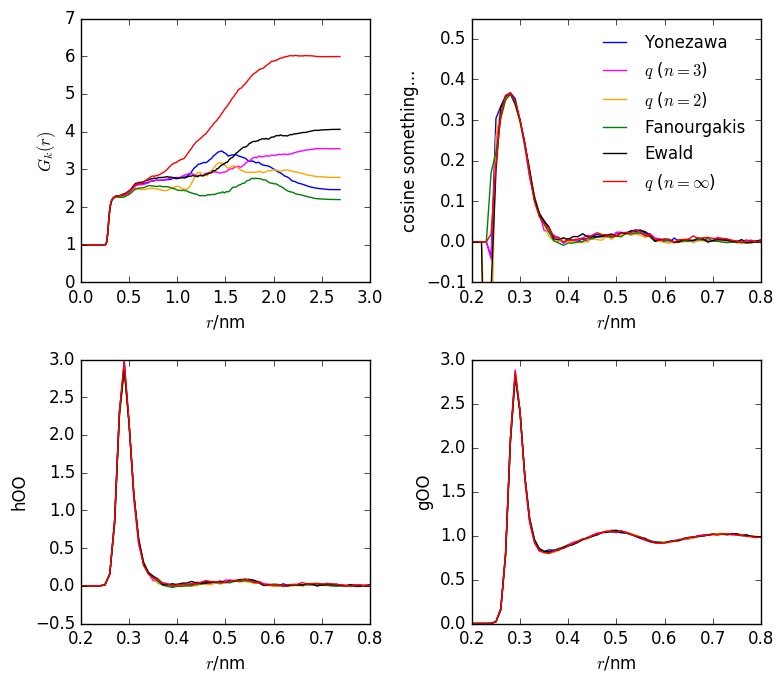

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(8, 7))

for name, prop in systemlist.items():
    r, G, cos, hOO, gOO, energy = np.loadtxt(name+'.gkr.xvg', skiprows=27, unpack=True)
    
    ax1.plot(r, G,   label=prop['label'], color=prop['color'], lw=1 )
    ax1.set_xlabel('$r$/nm')
    ax1.set_ylabel('$G_k(r)$')

    ax2.plot(r, cos, label=prop['label'], color=prop['color'], lw=1 )
    ax2.set_xlabel('$r$/nm')
    ax2.set_ylabel('cosine something...')
    ax2.set_xlim(0.2, 0.8)
    ax2.set_ylim(-0.1, 0.55)
    
    ax3.plot(r, hOO, label=prop['label'], color=prop['color'], lw=1 )
    ax3.set_xlabel('$r$/nm')
    ax3.set_ylabel('hOO')
    ax3.set_xlim(0.2, 0.8)
    
    ax4.plot(r, gOO, label=prop['label'], color=prop['color'], lw=1 )
    ax4.set_xlabel('$r$/nm')
    ax4.set_ylabel('gOO')
    ax4.set_xlim(0.2, 0.8)
    
    ax2.legend(loc=0, frameon=False, fontsize='medium')
plt.tight_layout()